In [1]:
from matplotlib import pyplot as plt
import torch
import torch.functional as F
import biosupcon as tools
import albumentations as A
import albumentations.pytorch as AT
import pandas as pd
scaler = torch.cuda.amp.GradScaler()

/home/ap/miniconda3/envs/bioencoder/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ckpt_pretrained = './weights/effnetb4_damselfly_stage1/swa'
data_dir = '/home/ap/Dropbox/Year_2023/morph_moritz_aligned/dataset2/'
valid_transforms = A.Compose([A.Resize(384, 384), A.Normalize(), AT.ToTensorV2()])

transform_dict = {
            "train_transforms": valid_transforms,
            'valid_transforms': valid_transforms}

num_classes = 4
batch_sizes = {
    "train_batch_size": 5,
    'valid_batch_size': 5
}
num_workers = 16
backbone = 'timm_tf_efficientnet_b0'
stage = 'first'

loaders = tools.utils.build_loaders(data_dir, transform_dict, batch_sizes, num_workers, second_stage=(stage == 'second'))
    

In [3]:
model = tools.utils.build_model(backbone, second_stage=(stage == 'second'), num_classes=num_classes, ckpt_pretrained=ckpt_pretrained).cuda()
model.use_projection_head(False)
model.eval()




tf_efficientnet_b0


SupConModel(
  (encoder): Sequential(
    (0): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (2): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [ ]:

embeddings_train, labels_train = tools.utils.compute_embeddings(loaders['valid_loader'], model, scaler)
paths_train = [item[0] for item in loaders['valid_loader'].dataset.imgs]
reduced_data, colnames, pca = tools.vis.embbedings_dimension_reductions(embeddings_train)

vis_x_train = reduced_data[:,2]
vis_y_train = reduced_data[:,3]

df = pd.DataFrame(reduced_data, columns=colnames)
df['paths'] = paths_train
df['class'] = labels_train
df['class_str']=[item[0].split('/')[-2] for item in loaders['valid_loader'].dataset.imgs]

In [ ]:
pca.explained_variance_ratio_

In [ ]:
tools.vis.bokeh_plot(df)

In [ ]:

# import required libraries
import numpy as np
from numpy.linalg import norm
cosine = np.dot(embeddings_train,embeddings_train.T)


In [ ]:

pd.DataFrame(cosine).to_csv('cosine.csv')

In [ ]:
pd.DataFrame(cosine)

In [4]:
import cv2
import numpy as np
img_path = '/home/ap/Dropbox/Year_2023/morph_moritz_aligned/biosup/val/androchrome/2017_07_15_time_14_02_47_481000_roi_02.jpg'


In [5]:
img = cv2.imread(img_path, 1)
img = cv2.resize(img,(1024,1024))
img = np.float32(img) / 255
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_img = tools.vis.preprocess_image(img)

In [ ]:
input_img.shape

In [ ]:
test = torch.cat([input_img, input_img], dim=0).cuda()
test.shape

In [ ]:
out = model(test)

In [ ]:
out[0].shape

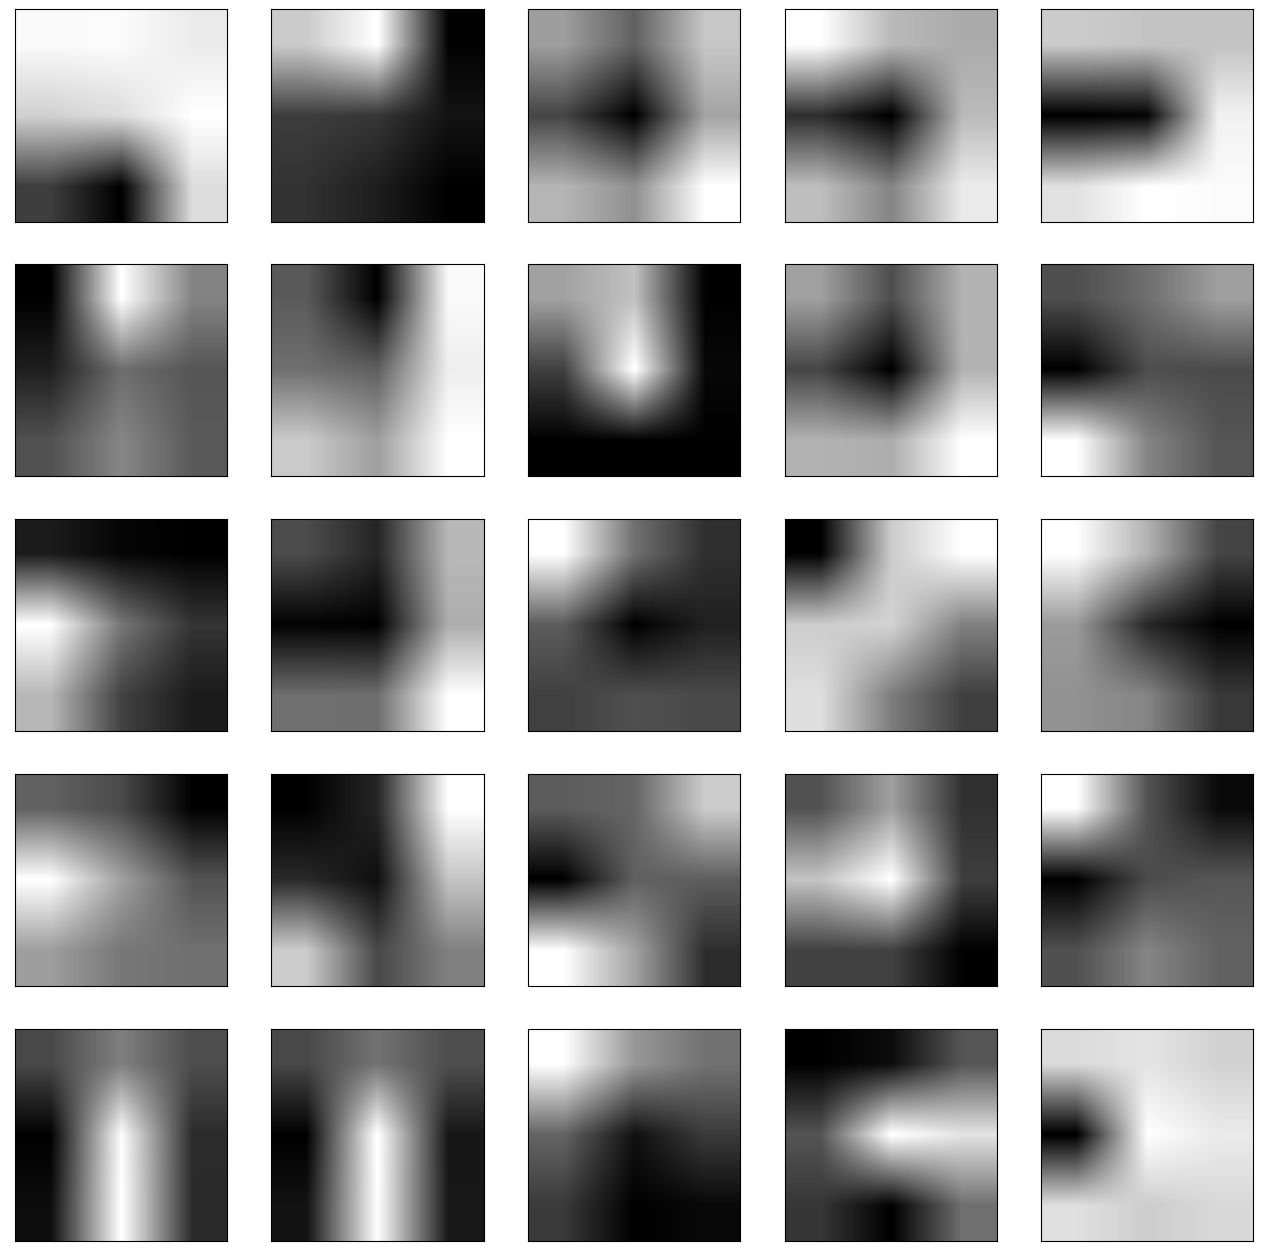

In [6]:
tools.vis.visualize_filters(model.encoder, 'encoder.4.weight', max_filters = 25)

In [ ]:
for param in model.named_parameters():
    print(param[0])

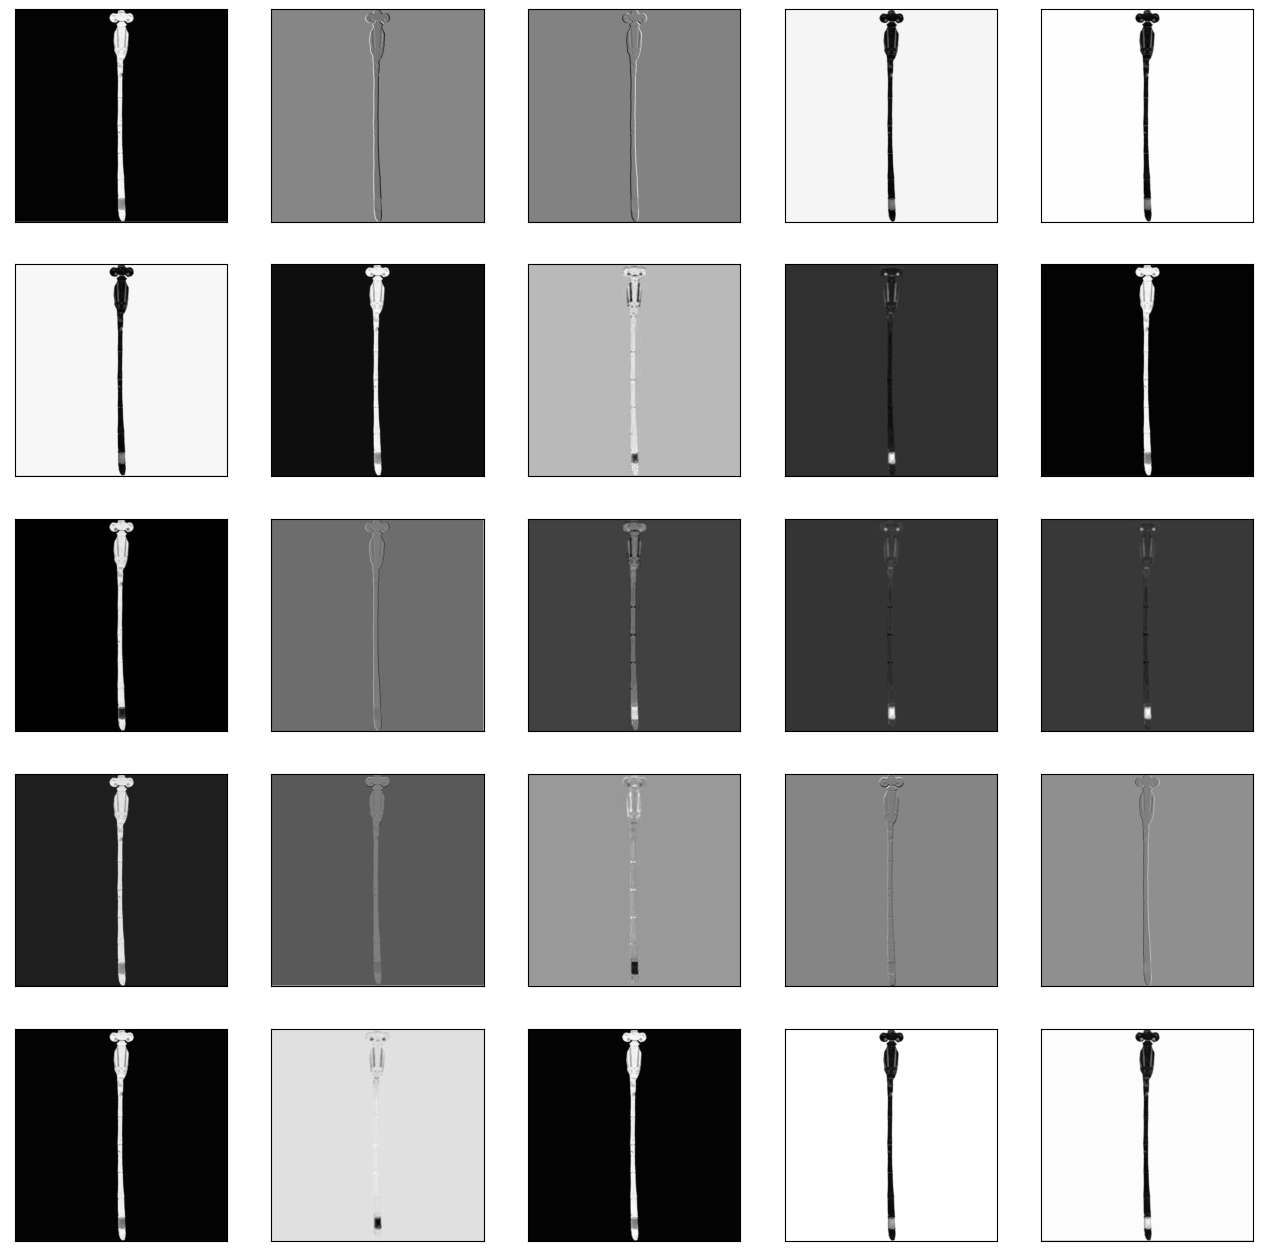

In [6]:
tools.vis.visualize_activations(model, model.encoder[0], img, device='cpu')

In [9]:
tools.vis.maximally_activated_patches(model, img, patch_size=384, device='cuda')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

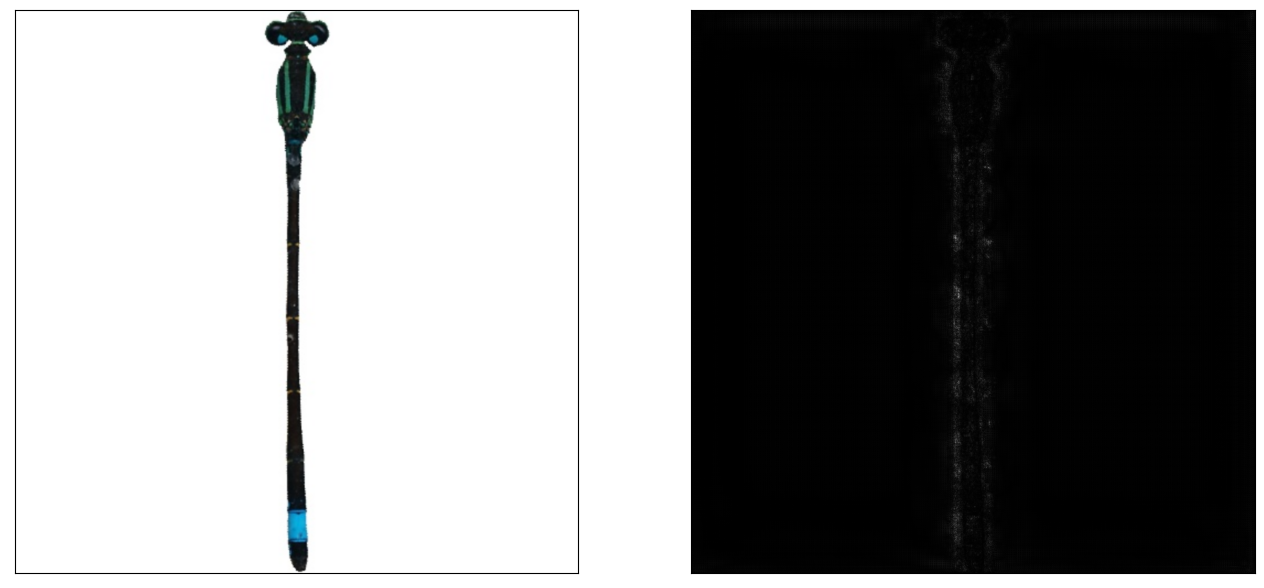

In [10]:
tools.vis.saliency_map(model,img)

tf_efficientnet_b0
Reached 0.9922685027122498 confidence score in epoch 3. Stopping early.


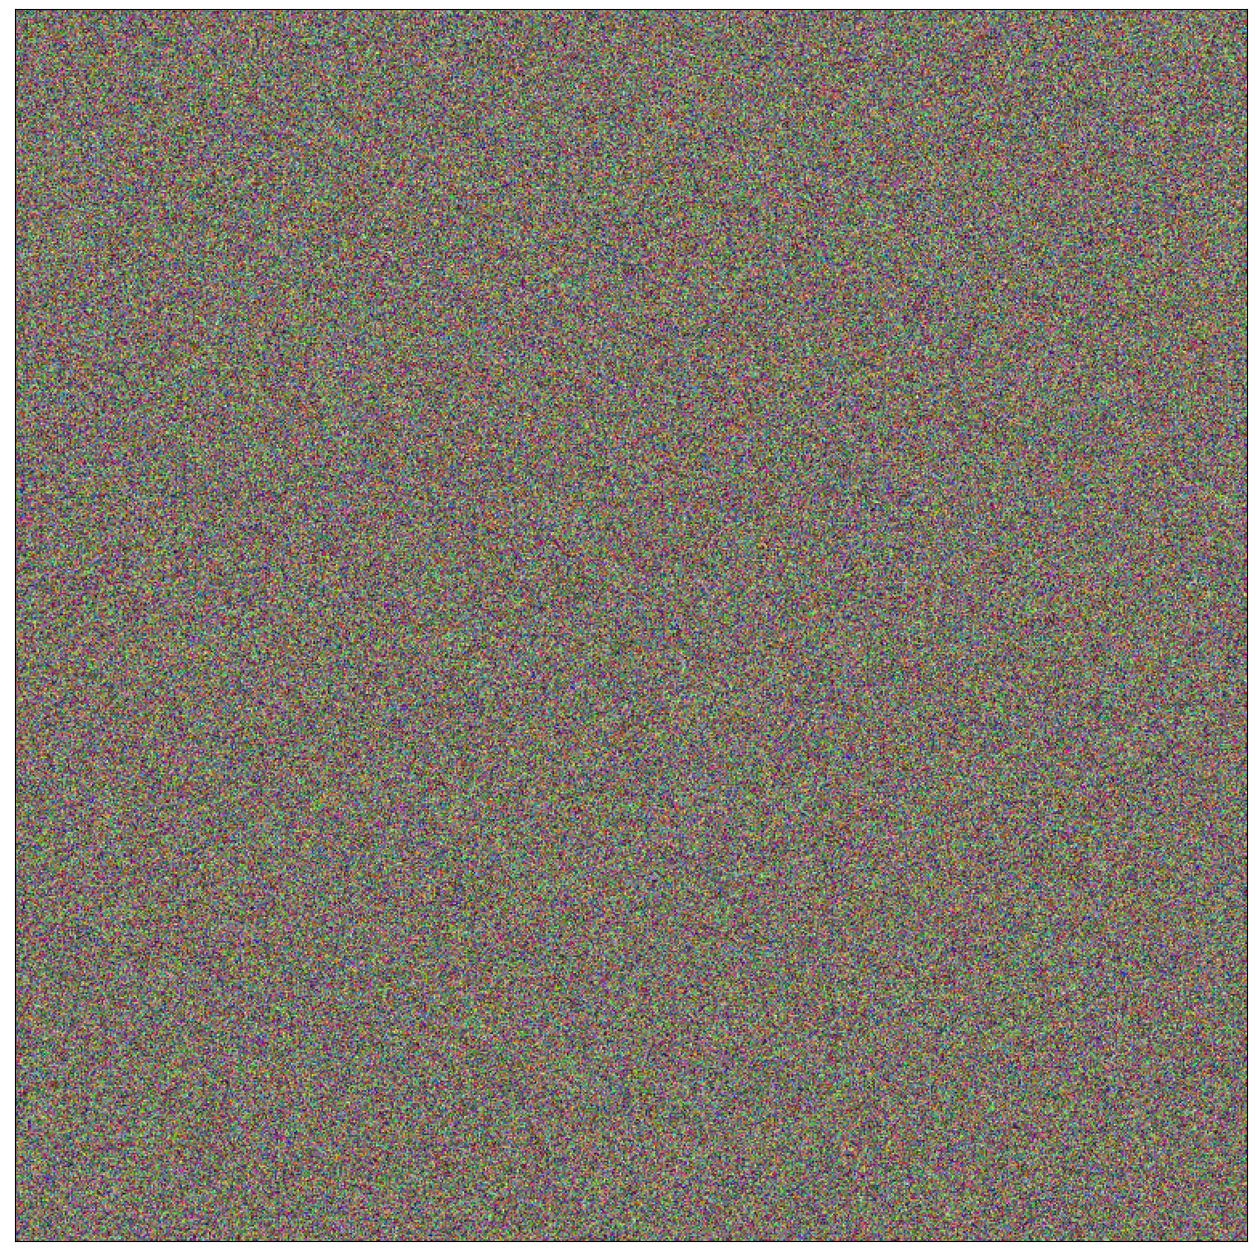

In [11]:
ckpt_pretrained = './weights/effnetb4_damselfly_stage2/swa'
model = tools.utils.build_model(backbone, second_stage='second', num_classes=4, ckpt_pretrained=ckpt_pretrained).cuda()
synthetic_image = tools.vis.generate_image(model = model, target_class = 3, epochs = 500, min_prob = 0.9, lr = 12, weight_decay = 1e-3,
                        step_size = 100, gamma = 0.9, noise_size=768)

In [12]:
test = tools.vis.fool_model(model, img, target_class=0, lr=12)

/home/ap/Dropbox/Year_2023/BioSupCon/biosupcon/vis/methods.py:307: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(outs)[target_class]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [13]:
outs = model(input_img.cuda())


In [14]:
outs

tensor([[ 1.5074, -0.8959, -1.2990,  1.1188]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

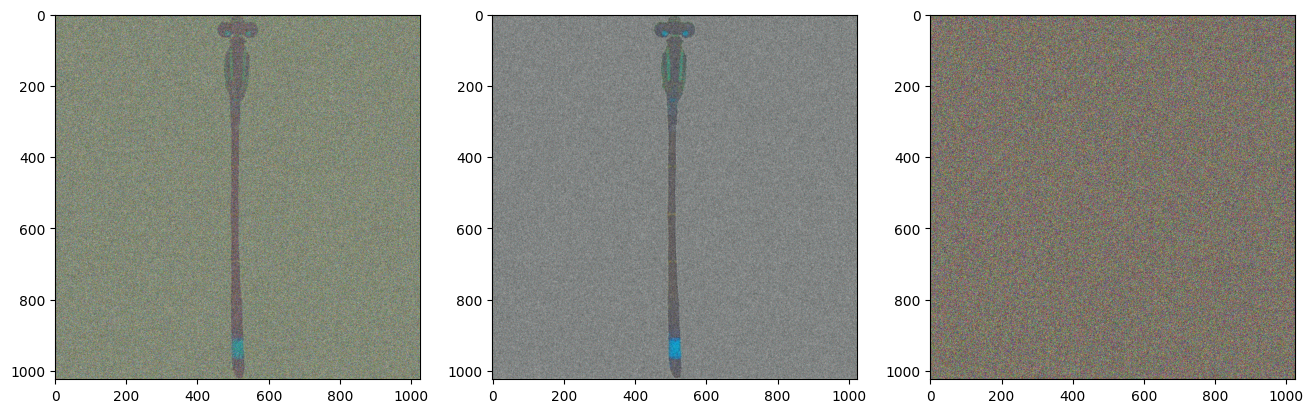

In [13]:
modules = [model.encoder[0],model.encoder[1], model.encoder[2]]
tools.vis.feature_inversion(model, modules,  img, 100, 5e-5)

tf_efficientnet_b0


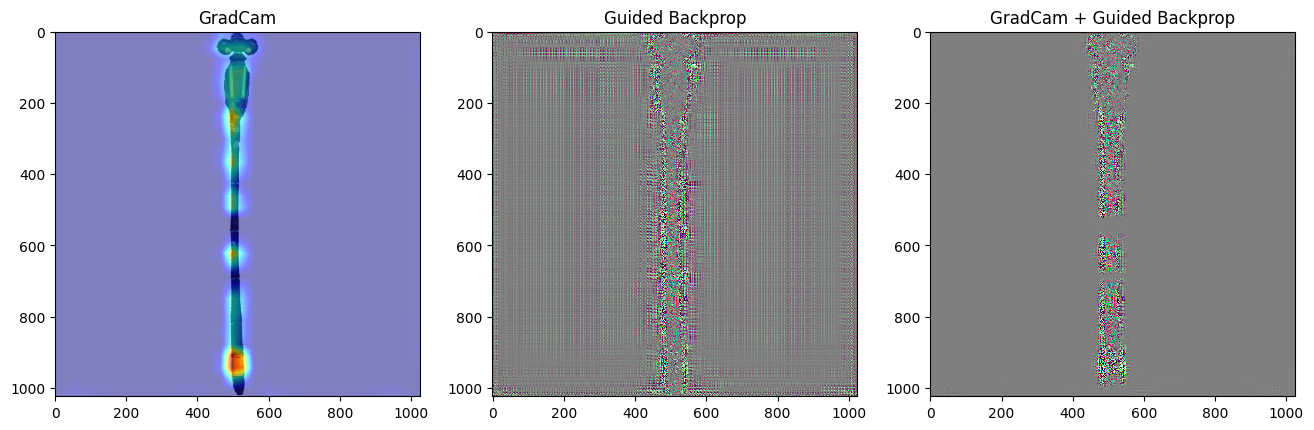

In [18]:
ckpt_pretrained = './weights/effnetb4_damselfly_stage2/swa'
model = tools.utils.build_model(backbone, second_stage='second', num_classes=4, ckpt_pretrained=ckpt_pretrained).cuda()

tools.vis.grad_cam(model, model.encoder,img,target_layer=["4"], target_category= None)

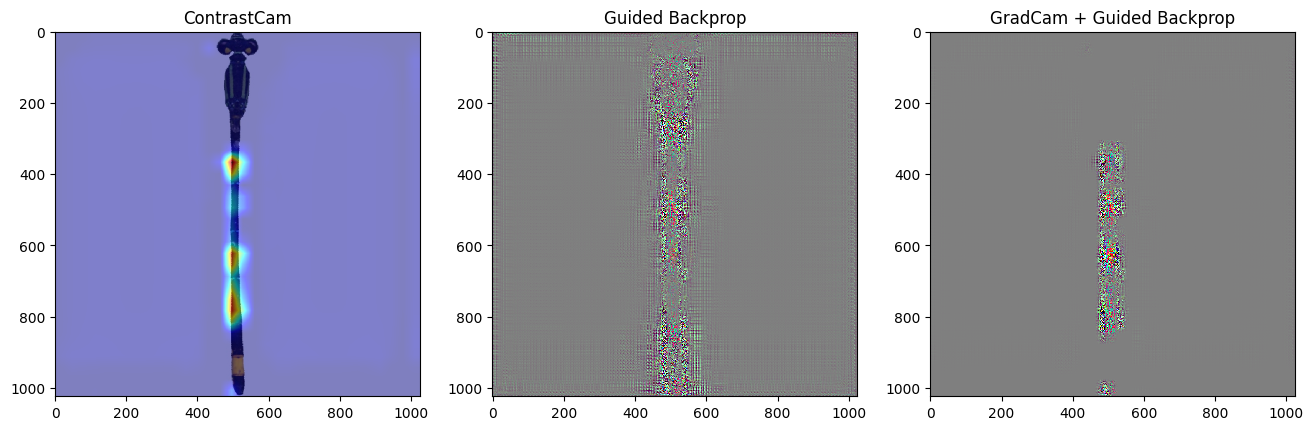

In [15]:


tools.vis.contrast_cam(model, model.encoder,img,target_layer=["4"], target_category= 3)

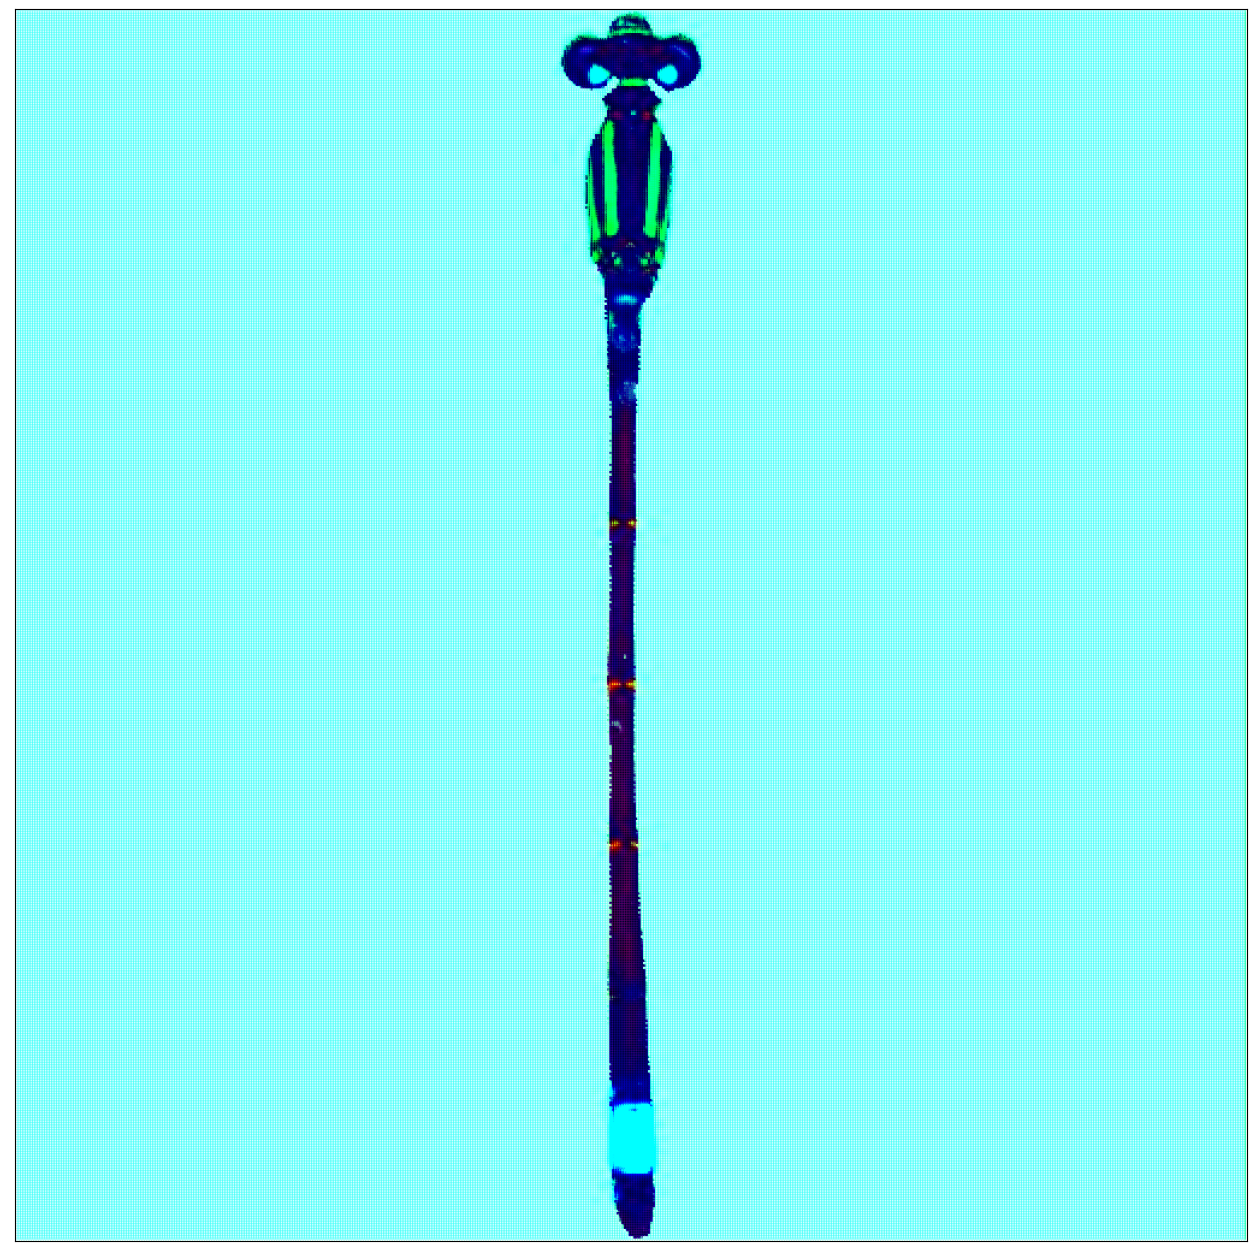

In [16]:
dream = tools.vis.deep_dream(model = model, module = model.encoder[0], img= img, epochs = 300, lr = 4)